In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ogw3-loaded/data_frames_ogw3.pkl


In [2]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import re
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import layers, Model, Input
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [3]:
%pwd
os.chdir("..")
%pwd
os.chdir("input")
obj=pd.read_pickle('ogw3-loaded/data_frames_ogw3.pkl')
for k, v in obj.items():
    print(k)
    print(v.shape)
    break

data_all_20191121T101124_D3_S5_R2_200kHz.csv
(4369, 66)


In [4]:
# Define the columns to extract (0-based indexing)
# columns_to_extract = [26, 34, 27, 35]  # Columns 27, 35, 28, 36 in 1-based indexing
columns_to_extract = [26]  # Columns 27 in 1-based indexing
baseline_data = {}
damage_data = {}

In [5]:
for k, v in obj.items():
    # Use regex to find the frequency (digits followed by "kHz") in the key.
    freq_match = re.search(r'(\d+)kHz', k)
    if freq_match:
        frequency_val = int(freq_match.group(1))  # e.g., 40, 60, ..., 260
    else:
        frequency_val = None

    if 'baseline' in k:
        # Filter the data
        if isinstance(v, pd.DataFrame):
            filtered_data = v.iloc[:, columns_to_extract].values  # .values to get numpy array
        else:
            filtered_data = v[:, columns_to_extract]
        
        # Save the filtered data and frequency; baseline samples have damage label 0.
        baseline_data[k] = {
            'data': filtered_data,   # Expected shape: (4369, 1)
            'frequency': frequency_val
        }
        
    elif 'D1' in k:  # For damage cases
        if isinstance(v, pd.DataFrame):
            filtered_data = v.iloc[:, columns_to_extract].values
        else:
            filtered_data = v[:, columns_to_extract]
        
        # Extract the damage size from a part that starts with 'S'
        damage_size_part = [part for part in k.split('_') if part.startswith('S')]
        if damage_size_part:
            damage_size = int(damage_size_part[0][1:])  # e.g., "S1" -> 1
        else:
            damage_size = None
        
        damage_data[k] = {
            'data': filtered_data,   # Expected shape: (4369, 1)
            'damage_size': damage_size,
            'frequency': frequency_val
        }

In [6]:
from sklearn.utils import shuffle

# Define number of classes
num_damage_classes = 14   # 0: undamaged; 1-13: damage sizes
num_freq_classes = 12     # Frequencies: 40, 60, ..., 260 kHz

In [7]:
# Helper functions for one-hot encoding
def one_hot_damage(label):
    one_hot = np.zeros(num_damage_classes)
    # Ensure label is within valid range [0, num_damage_classes-1]
    if 0 <= label < num_damage_classes:
        one_hot[label] = 1
    else:
        raise ValueError(f"Damage label {label} is out of bounds.")
    return one_hot

def one_hot_frequency(freq):
    # Map frequency (e.g., 40, 60, ...) to an index between 0 and 11.
    if freq is None:
        raise ValueError("Frequency value is None.")
    freq_index = (freq - 40) // 20  # e.g., 40 -> 0, 60 -> 1, ..., 260 -> 11
    one_hot = np.zeros(num_freq_classes)
    if 0 <= freq_index < num_freq_classes:
        one_hot[int(freq_index)] = 1
    else:
        raise ValueError(f"Frequency {freq} kHz is out of expected range.")
    return one_hot

In [8]:
# Lists to accumulate the training data
signal_list = []
damage_list = []
frequency_list = []

In [9]:
# Process baseline data (undamaged samples with damage label 0)
for key, entry in baseline_data.items():
    signal = entry['data']          # Expected shape: (4369, 1)
    frequency = entry['frequency']  # e.g., 40, 60, ... 260
    # Skip sample if frequency is missing
    if frequency is None:
        continue
    signal_list.append(signal)
    damage_list.append(one_hot_damage(0))   # Baseline samples are undamaged
    frequency_list.append(one_hot_frequency(frequency))

In [10]:
# Process damage data (samples with damage)
for key, entry in damage_data.items():
    signal = entry['data']           # Expected shape: (4369, 1)
    frequency = entry['frequency']
    damage_size = entry['damage_size']  # e.g., 1, 2, ..., 13
    # Skip sample if required information is missing
    if frequency is None or damage_size is None:
        continue
    signal_list.append(signal)
    damage_list.append(one_hot_damage(damage_size))
    frequency_list.append(one_hot_frequency(frequency))


In [11]:
# Convert lists to NumPy arrays
X_signals = np.array(signal_list)       # Shape: (num_samples, 4369, 1)
X_damage = np.array(damage_list)          # Shape: (num_samples, 14)
X_freq = np.array(frequency_list)         # Shape: (num_samples, 12)

In [12]:
# Reshape X for scaling (since MinMaxScaler expects 2D input)
X_reshaped = X_signals.reshape(X_signals.shape[0], -1)  # Shape: (n_samples, 4369)

# Apply MinMaxScaler to scale between [-1,1]
scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X_reshaped)

# Reshape back to original shape
X_scaled = X_scaled.reshape(X_signals.shape[0], X_signals.shape[1], 1)  # Shape: (n_samples, 4369, 1)

In [13]:
X_signals=X_scaled

In [14]:
# In our CVAE, the target is the same as the input signal (for reconstruction).
y_signals = X_signals.copy()

# Optionally, shuffle the dataset to mix baseline and damage samples.
X_signals, X_damage, X_freq, y_signals = shuffle(
    X_signals, X_damage, X_freq, y_signals, random_state=42
)

print("X_signals shape:", X_signals.shape)
print("X_damage shape:", X_damage.shape)
print("X_freq shape:", X_freq.shape)


X_signals shape: (1020, 4369, 1)
X_damage shape: (1020, 14)
X_freq shape: (1020, 12)


In [15]:
y_signals.max()

1.0000000000000004

In [22]:

# ------------------------------------------------------------------------------
#  Basic Parameters
# ------------------------------------------------------------------------------
input_length = 4369      # Length of each 1D signal
latent_dim = 50          # Dimensionality of the latent space
num_damage_classes = 14  # e.g. 0=undamaged; 1-13=damage sizes
num_freq_classes = 12    # Frequencies: 40 kHz, 60 kHz, ... 260 kHz
cond_dim = num_damage_classes + num_freq_classes  # = 26

In [23]:
# ------------------------------------------------------------------------------
#  ENCODER: Use several Conv1D layers followed by GlobalAveragePooling1D.
#  (This avoids flattening a huge feature map.)
# ------------------------------------------------------------------------------
signal_input = Input(shape=(input_length, 1), name="signal_input")
damage_input = Input(shape=(num_damage_classes,), name="damage_input")
freq_input   = Input(shape=(num_freq_classes,), name="freq_input")

# Convolutional layers:
x = layers.Conv1D(64, kernel_size=7, strides=2, activation="relu", padding="same")(signal_input)
# --> shape: approx (2185, 64)
x = layers.Conv1D(128, kernel_size=5, strides=2, activation="relu", padding="same")(x)
# --> shape: approx (1093, 128)
x = layers.Conv1D(256, kernel_size=3, strides=2, activation="relu", padding="same")(x)
# --> shape: approx (547, 256)
x = layers.Conv1D(512, kernel_size=3, strides=2, activation="relu", padding="same")(x)
# --> shape: approx (274, 512)

# Instead of flattening the (274×512) feature map (which would be huge),
# we use GlobalAveragePooling1D to obtain a fixed 512‐dimensional vector.
x = layers.GlobalAveragePooling1D()(x)  # shape: (512,)

# Concatenate the learned features with the condition vector.
conditions = layers.Concatenate(name="concat_conditions")([damage_input, freq_input])
x = layers.Concatenate(name="encoder_concat")([x, conditions])  # shape: (512+26 = 538,)

# A moderate dense layer (to keep the parameter count in check)
x = layers.Dense(512, activation="relu")(x)  # roughly 538*512 ~ 275K params

# Produce latent-space parameters
z_mean = layers.Dense(latent_dim, name="z_mean")(x)       # 512*50 ~ 25K params
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)   # similar size


In [24]:
# Reparameterization trick:
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])

In [25]:
encoder = Model(inputs=[signal_input, damage_input, freq_input],
                outputs=[z_mean, z_log_var, z],
                name="encoder")
encoder.summary()  # Expect roughly ~0.9M parameters (~860K) in the encoder

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ signal_input (InputLayer) │ (None, 4369, 1)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 2185, 64)       │            512 │ signal_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, 1093, 128)      │         41,088 │ conv1d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_6 (Conv1D)         │ (None, 547, 256)       │         98,560 │ conv1d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_7 (Conv1D)         │ (None, 274, 512)       │        393,728 │ conv1d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ damage_input (InputLayer) │ (None, 14)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ freq_input (InputLayer)   │ (None, 12)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 512)            │              0 │ conv1d_7[0][0]         │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat_conditions         │ (None, 26)             │              0 │ damage_input[0][0],    │
│ (Concatenate)             │                        │                │ freq_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_concat            │ (None, 538)            │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ concat_conditions[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 512)            │        275,968 │ encoder_concat[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 50)             │         25,650 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 50)             │         25,650 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z (Lambda)                │ (None, 50)             │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 861,156 (3.29 MB)

 Trainable params: 861,156 (3.29 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# ------------------------------------------------------------------------------
#  DECODER: Project latent+condition to a seed feature map then upsample.
# ------------------------------------------------------------------------------
# Inputs for the decoder
latent_inputs = Input(shape=(latent_dim,), name="z_sampling")
decoder_cond_input = Input(shape=(cond_dim,), name="decoder_cond_input")

# Concatenate latent and condition
decoder_input = layers.Concatenate(name="decoder_input")([latent_inputs, decoder_cond_input])
# Now the combined vector has dimension 50+26 = 76

# Dense projection to a seed feature map.
# We choose a seed shape of (35, 256). (35 * 256 = 8960.)
# (Increasing the seed resolution and filter count here increases the parameter count.)
seed_units = 35 * 256
x = layers.Dense(seed_units, activation="relu")(decoder_input)
x = layers.Reshape((35, 256))(x)  # Seed shape

# We need to upsample from length 35 to nearly 4369.
# Notice: 35 * 2^7 = 35 * 128 = 4480 (a bit above 4369)
# We use 7 UpSampling blocks, with Conv1D processing at each scale.
# (These blocks are designed so that the total parameter count is on the order of 1M.)
x = layers.UpSampling1D(size=2)(x)  # 35 -> 70
x = layers.Conv1D(256, kernel_size=3, activation="relu", padding="same")(x)

x = layers.UpSampling1D(size=2)(x)  # 70 -> 140
x = layers.Conv1D(256, kernel_size=3, activation="relu", padding="same")(x)

x = layers.UpSampling1D(size=2)(x)  # 140 -> 280
x = layers.Conv1D(128, kernel_size=3, activation="relu", padding="same")(x)

x = layers.UpSampling1D(size=2)(x)  # 280 -> 560
x = layers.Conv1D(128, kernel_size=3, activation="relu", padding="same")(x)

x = layers.UpSampling1D(size=2)(x)  # 560 -> 1120
x = layers.Conv1D(64, kernel_size=3, activation="relu", padding="same")(x)

x = layers.UpSampling1D(size=2)(x)  # 1120 -> 2240
x = layers.Conv1D(64, kernel_size=3, activation="relu", padding="same")(x)

x = layers.UpSampling1D(size=2)(x)  # 2240 -> 4480
x = layers.Conv1D(32, kernel_size=3, activation="relu", padding="same")(x)

# Final projection to 1 channel.
x = layers.Conv1D(1, kernel_size=3, activation="linear", padding="same")(x)
# Now x has shape (4480, 1). We need to crop to exactly 4369.
x = layers.Cropping1D(cropping=(55, 56))(x)  # Crops a total of 111 samples (4480 - 111 = 4369)

decoder_output = x


In [27]:
decoder = Model(inputs=[latent_inputs, decoder_cond_input],
                outputs=decoder_output,
                name="decoder")
decoder.summary()  # Expect roughly ~1.3M parameters (you can tweak filter counts if needed)


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)   │ (None, 50)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_cond_input        │ (None, 26)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_input             │ (None, 76)             │              0 │ z_sampling[0][0],      │
│ (Concatenate)             │                        │                │ decoder_cond_input[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 8960)           │        689,920 │ decoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 35, 256)        │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling1d             │ (None, 70, 256)        │              0 │ reshape[0][0]          │
│ (UpSampling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_8 (Conv1D)         │ (None, 70, 256)        │        196,864 │ up_sampling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling1d_1           │ (None, 140, 256)       │              0 │ conv1d_8[0][0]         │
│ (UpSampling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_9 (Conv1D)         │ (None, 140, 256)       │        196,864 │ up_sampling1d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling1d_2           │ (None, 280, 256)       │              0 │ conv1d_9[0][0]         │
│ (UpSampling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_10 (Conv1D)        │ (None, 280, 128)       │         98,432 │ up_sampling1d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling1d_3           │ (None, 560, 128)       │              0 │ conv1d_10[0][0]        │
│ (UpSampling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_11 (Conv1D)        │ (None, 560, 128)       │         49,280 │ up_sampling1d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling1d_4           │ (None, 1120, 128)      │              0 │ conv1d_11[0][0]        │
│ (UpSampling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_12 (Conv1D)        │ (None, 1120, 64)       │         24,640 │ up_sampling1d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling1d_5           │ (None, 2240, 64)       │              0 │ conv1d_12[0][0]        │
│ (UpSampling1D)       

 Total params: 1,274,625 (4.86 MB)

 Trainable params: 1,274,625 (4.86 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# ------------------------------------------------------------------------------
#  CVAE Model
# ------------------------------------------------------------------------------
class CVAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
        
    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]
    
    def train_step(self, data):
        # data: ((signal, damage, freq), target)
        (signal, damage, freq), target = data
        cond = tf.concat([damage, freq], axis=-1)
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder([signal, damage, freq])
            reconstruction = self.decoder([z, cond])
            # Mean squared error reconstruction loss:
            reconstruction_loss = tf.reduce_mean(tf.square(tf.reshape(target, [-1, input_length]) -
                                                            tf.reshape(reconstruction, [-1, input_length])))
            # KL divergence loss:
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
            )
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }
    
    def call(self, inputs):
        # For inference: inputs = (signal, damage, freq)
        signal, damage, freq = inputs
        cond = tf.concat([damage, freq], axis=-1)
        _, _, z = self.encoder([signal, damage, freq])
        return self.decoder([z, cond])


In [29]:
# Instantiate and compile the CVAE.
cvae = CVAE(encoder, decoder)
# Because we use a custom train_step, provide a dummy loss.
cvae.compile(optimizer=tf.keras.optimizers.Adam(), loss=lambda y_true, y_pred: 0)

In [30]:
cvae.summary()

Model: "cvae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder (Functional)                 │ [(None, 50), (None, 50),    │         861,156 │
│                                      │ (None, 50)]                 │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 4369, 1)             │       1,274,625 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,135,781 (8.15 MB)

 Trainable params: 2,135,781 (8.15 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
cvae.fit(
    (X_signals, X_damage, X_freq),  # Input: signal, damage condition, frequency condition
    y_signals,                      # Target: signal (for reconstruction)
    epochs=50,                      # Adjust number of epochs as needed
    batch_size=32,                  # Adjust batch size as needed
    validation_split=0.1            # Or use separate validation data
)

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 257ms/step - kl_loss: 0.0419 - loss: 0.2761 - reconstruction_loss: 0.2342 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - kl_loss: 3.3798e-05 - loss: 0.1487 - reconstruction_loss: 0.1486 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - kl_loss: 1.0567e-05 - loss: 0.1134 - reconstruction_loss: 0.1134 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - kl_loss: 6.2292e-06 - loss: 0.0928 - reconstruction_loss: 0.0928 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - kl_loss: 1.2992e-06 - loss: 0.0799 - reconstruction_loss: 0.0799 - val_kl_loss: 0.0000e+00 - val_reconstr

In [32]:
from sklearn.model_selection import train_test_split

# Split into training and testing sets (80% train, 20% test)
X_train_signals, X_test_signals, X_train_damage, X_test_damage, X_train_freq, X_test_freq, y_train_signals, y_test_signals = train_test_split(
    X_signals, X_damage, X_freq, y_signals, test_size=0.2, random_state=42
)

# Print shapes to verify
print("Train Set:")
print("X_signals_train shape:", X_train_signals.shape)
print("X_damage_train shape:", X_train_damage.shape)
print("X_freq_train shape:", X_train_freq.shape)
print("y_signals_train shape:", y_train_signals.shape)

print("\nTest Set:")
print("X_signals_test shape:", X_test_signals.shape)
print("X_damage_test shape:", X_test_damage.shape)
print("X_freq_test shape:", X_test_freq.shape)
print("y_signals_test shape:", y_test_signals.shape)


Train Set:
X_signals_train shape: (816, 4369, 1)
X_damage_train shape: (816, 14)
X_freq_train shape: (816, 12)
y_signals_train shape: (816, 4369, 1)

Test Set:
X_signals_test shape: (204, 4369, 1)
X_damage_test shape: (204, 14)
X_freq_test shape: (204, 12)
y_signals_test shape: (204, 4369, 1)


In [33]:
# -----------------------------
# 1. Reconstruction Performance
# -----------------------------

# Use the CVAE's call method (or predict) to generate reconstructions.
# The call() method of our CVAE is defined to accept a tuple (signal, damage, freq).
reconstructed_signals = cvae.predict((X_test_signals, X_test_damage, X_test_freq))

# Compute the Mean Squared Error (MSE) between original and reconstructed signals.
# Here, we reshape the signals to 2D arrays (num_samples, 4369) for the MSE computation.
mse = np.mean(np.square(
    y_test_signals.reshape(y_test_signals.shape[0], -1) - 
    reconstructed_signals.reshape(reconstructed_signals.shape[0], -1)
))
print("Test Reconstruction MSE:", mse)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step
Test Reconstruction MSE: 0.018872520964865108


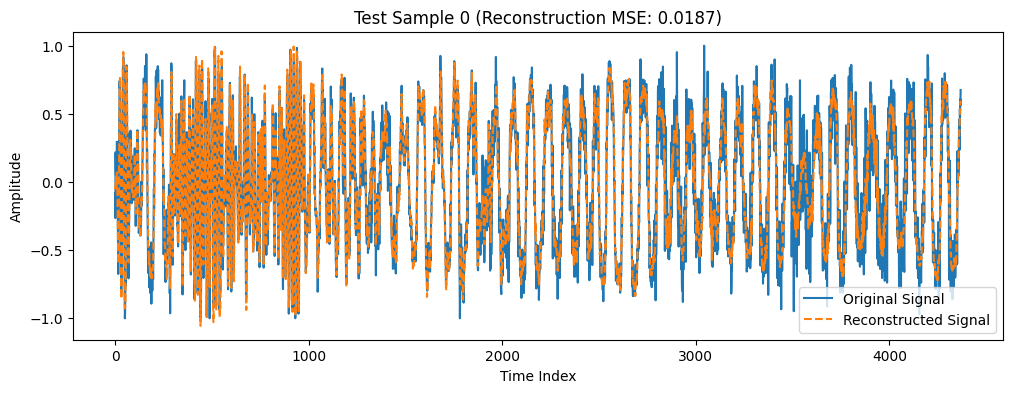

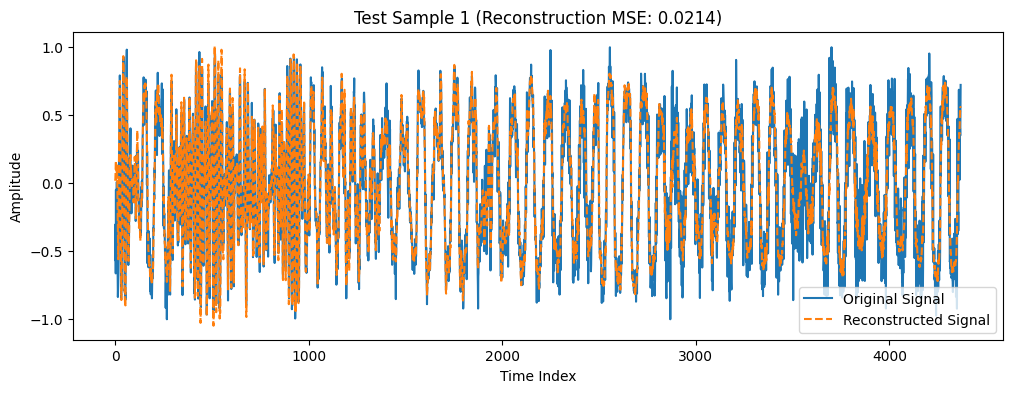

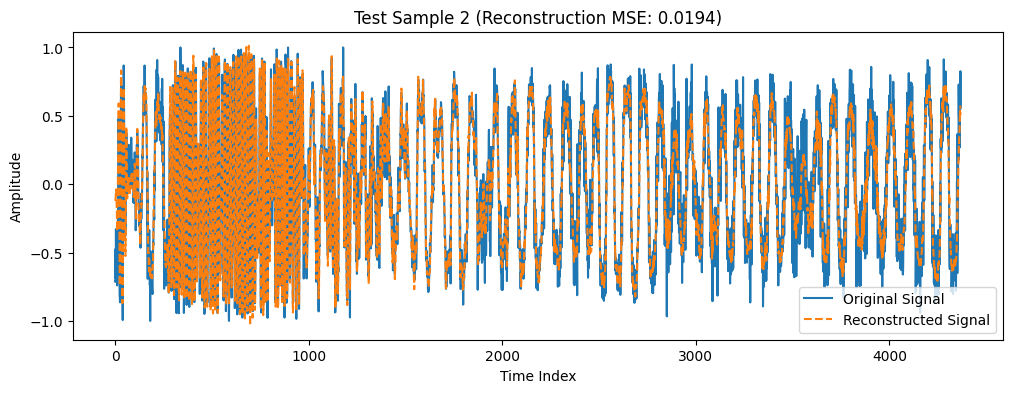

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
Average Test KL Divergence: -8.940697e-08


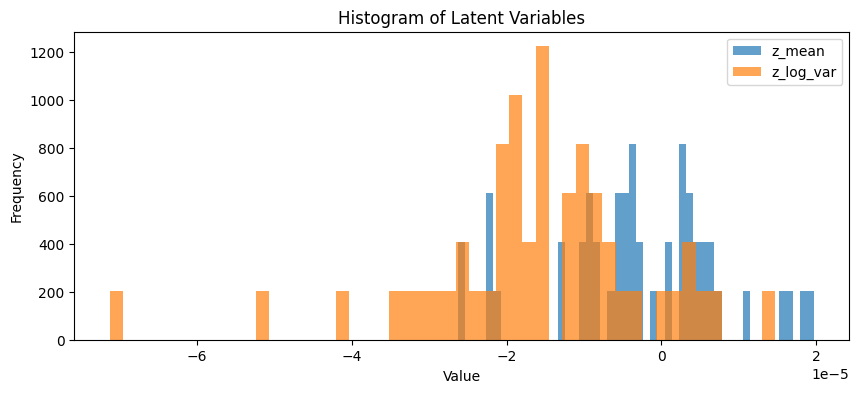

In [34]:
import numpy as np
import matplotlib.pyplot as plt



# -----------------------------
# 2. Visualize Reconstructions
# -----------------------------

num_samples_to_plot = 3  # Number of test examples to visualize

for i in range(num_samples_to_plot):
    plt.figure(figsize=(12, 4))
    plt.plot(y_test_signals[i].squeeze(), label='Original Signal')
    plt.plot(reconstructed_signals[i].squeeze(), label='Reconstructed Signal', linestyle='--')
    sample_mse = np.mean(np.square(y_test_signals[i] - reconstructed_signals[i]))
    plt.title(f"Test Sample {i} (Reconstruction MSE: {sample_mse:.4f})")
    plt.xlabel("Time Index")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

# -----------------------------
# 3. Evaluate the Latent Space
# -----------------------------

# You can inspect the latent variables (z_mean and z_log_var) by passing test data through the encoder.
z_mean, z_log_var, _ = cvae.encoder.predict((X_test_signals, X_test_damage, X_test_freq))

# Compute the average KL divergence loss for the test set.
# KL divergence per sample: -0.5 * sum(1 + z_log_var - z_mean^2 - exp(z_log_var))
kl_divergences = -0.5 * np.sum(1 + z_log_var - np.square(z_mean) - np.exp(z_log_var), axis=1)
avg_kl = np.mean(kl_divergences)
print("Average Test KL Divergence:", avg_kl)

# Optionally, plot histograms of the latent means and log variances.
plt.figure(figsize=(10, 4))
plt.hist(z_mean.flatten(), bins=50, alpha=0.7, label="z_mean")
plt.hist(z_log_var.flatten(), bins=50, alpha=0.7, label="z_log_var")
plt.title("Histogram of Latent Variables")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
Generated signals with Damage Label: 3 and Frequency: 100 kHz


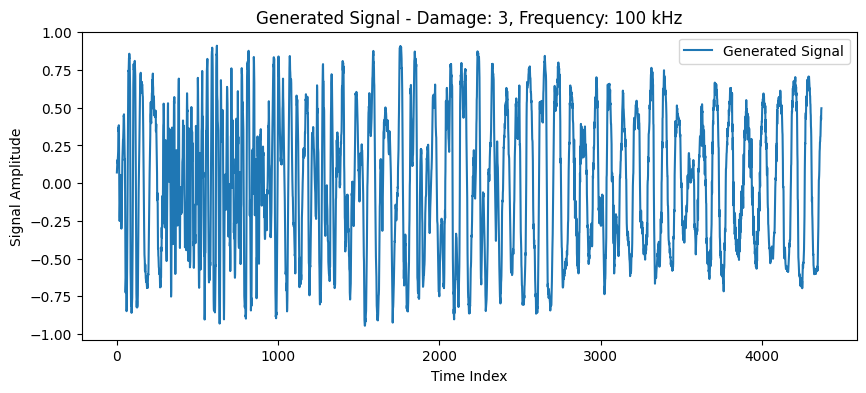

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Assume latent_dim is defined from your CVAE architecture.
# Also assume that the `decoder` model and the function `generate_augmented_signals`
# have already been defined as in the previous code snippet.

def generate_augmented_signals(num_samples, desired_damage_index, desired_freq_index):
    """
    Generates new guided wave signals using the trained decoder.

    Parameters:
        num_samples: Number of new signals to generate.
        desired_damage_index: Integer (0 to 13) for the damage condition.
                              0 for undamaged (baseline), 1-13 for damage sizes.
        desired_freq_index: Integer (0 to 11) corresponding to frequency.
                            E.g., 0: 40 kHz, 1: 60 kHz, ..., 11: 260 kHz.

    Returns:
        generated_signals: Array of generated signals with shape (num_samples, 4369, 1).
    """
    num_damage_classes = 14
    num_freq_classes = 12

    # Create one-hot vectors for the damage and frequency conditions.
    damage_condition = np.zeros((num_samples, num_damage_classes))
    damage_condition[:, desired_damage_index] = 1

    freq_condition = np.zeros((num_samples, num_freq_classes))
    freq_condition[:, desired_freq_index] = 1

    # For the decoder, we assume that the condition is the concatenation of the two one-hot vectors.
    decoder_condition = np.concatenate([damage_condition, freq_condition], axis=-1)

    # Sample latent vectors from a standard normal distribution.
    z_sample = np.random.normal(size=(num_samples, latent_dim))

    # Generate signals using the decoder.
    generated_signals = decoder.predict([z_sample, decoder_condition])
    return generated_signals

# Frequency mapping from index to actual frequency in kHz.
freq_mapping = {
    0: 40, 1: 60, 2: 80, 3: 100, 4: 120, 5: 140,
    6: 160, 7: 180, 8: 200, 9: 220, 10: 240, 11: 260
}

# Specify the desired damage label and frequency index.
desired_damage_index = 3   # For example, damage label "3"
desired_freq_index = 3     # For example, corresponds to 100 kHz

# Generate new signals.
new_signals = generate_augmented_signals(num_samples=10,
                                         desired_damage_index=desired_damage_index,
                                         desired_freq_index=desired_freq_index)

# Retrieve the actual frequency value from the mapping.
actual_frequency = freq_mapping[desired_freq_index]

# Print damage and frequency info.
print(f"Generated signals with Damage Label: {desired_damage_index} and Frequency: {actual_frequency} kHz")

# Plot one of the generated signals (for example, the first one).
plt.figure(figsize=(10, 4))
plt.plot(new_signals[0].flatten(), label="Generated Signal")
plt.title(f"Generated Signal - Damage: {desired_damage_index}, Frequency: {actual_frequency} kHz")
plt.xlabel("Time Index")
plt.ylabel("Signal Amplitude")
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


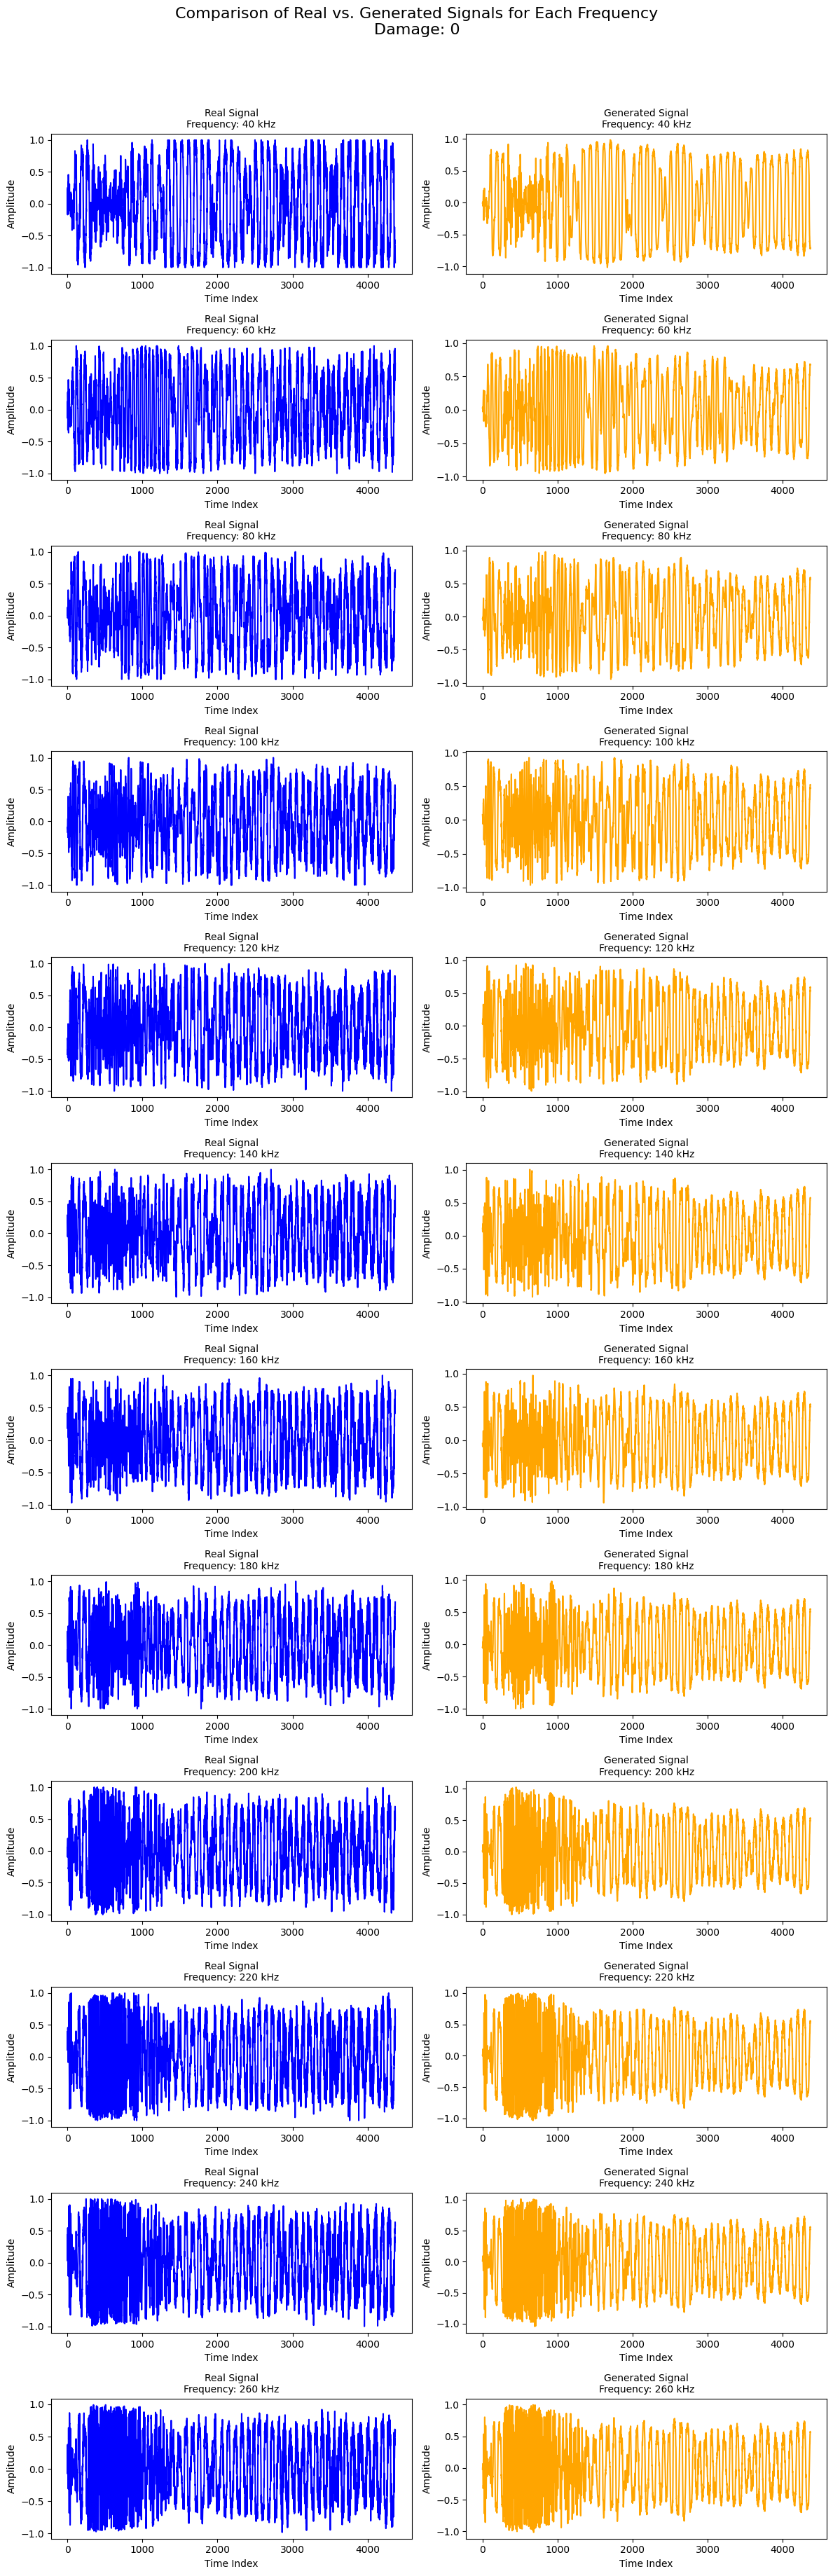

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Frequency mapping (index -> frequency in kHz).
freq_mapping = {
    0: 40, 1: 60, 2: 80, 3: 100, 4: 120, 5: 140,
    6: 160, 7: 180, 8: 200, 9: 220, 10: 240, 11: 260
}

# Fixed damage condition (for example, baseline damage label 0).
fixed_damage_index = 0
num_freq_classes = 12

# Create a figure with 12 rows (one per frequency) and 2 columns:
# Left column: real signal; Right column: generated signal.
fig, axes = plt.subplots(nrows=num_freq_classes, ncols=2, figsize=(12, num_freq_classes * 3))
fig.suptitle(f"Comparison of Real vs. Generated Signals for Each Frequency\nDamage: {fixed_damage_index}", fontsize=16, y=1.02)

# Loop over each frequency class.
for freq_class in range(num_freq_classes):
    # Create a mask to select test samples matching the fixed damage and current frequency.
    test_mask = (
        (np.argmax(X_test_freq, axis=1) == freq_class) &
        (np.argmax(X_test_damage, axis=1) == fixed_damage_index)
    )
    
    # Select one real sample if available.
    if np.sum(test_mask) > 0:
        real_signal = X_test_signals[test_mask][0]
    else:
        real_signal = None

    # Generate one augmented signal for the current frequency and fixed damage.
    generated_signal = generate_augmented_signals(num_samples=1,
                                                  desired_damage_index=fixed_damage_index,
                                                  desired_freq_index=freq_class)
    generated_signal = generated_signal[0]  # extract the single generated sample

    # Plot the real signal in the left column.
    ax_real = axes[freq_class, 0]
    if real_signal is not None:
        ax_real.plot(real_signal.flatten(), color="blue")
        ax_real.set_title(f"Real Signal\nFrequency: {freq_mapping[freq_class]} kHz", fontsize=10)
    else:
        ax_real.text(0.5, 0.5, "No Real Signal", ha="center", va="center")
        ax_real.set_title(f"Real Signal\nFrequency: {freq_mapping[freq_class]} kHz", fontsize=10)
    ax_real.set_xlabel("Time Index")
    ax_real.set_ylabel("Amplitude")

    # Plot the generated signal in the right column.
    ax_gen = axes[freq_class, 1]
    ax_gen.plot(generated_signal.flatten(), color="orange")
    ax_gen.set_title(f"Generated Signal\nFrequency: {freq_mapping[freq_class]} kHz", fontsize=10)
    ax_gen.set_xlabel("Time Index")
    ax_gen.set_ylabel("Amplitude")

plt.tight_layout()
plt.show()


In [45]:
os.chdir("..")
os.chdir("working")

In [46]:
%pwd

'/kaggle/working'

In [47]:
# Save just the model weights.
cvae.save_weights('cvae.weights.h5')


In [51]:
cvae.save('convolutional_cvae_model.h5')


In [52]:
X_signals.shape

(1020, 4369, 1)

In [53]:
num_train_samples = X_signals.shape[0]

# Lists to collect augmented samples.
aug_signals_list = []
aug_damage_list = []
aug_freq_list = []

In [54]:
for i in range(num_train_samples):
    # Determine the damage and frequency conditions for the current sample.
    # We use argmax on the one-hot encoded arrays to recover the condition index.
    damage_idx = int(np.argmax(X_damage[i]))
    freq_idx = int(np.argmax(X_freq[i]))
    
    # Generate one new sample for this condition.
    # (num_samples=1 returns an array with shape (1, 4369, 1); we take the first element.)
    new_sample = generate_augmented_signals(num_samples=1,
                                             desired_damage_index=damage_idx,
                                             desired_freq_index=freq_idx)
    
    # Append the generated sample and the corresponding conditions.
    aug_signals_list.append(new_sample[0])
    aug_damage_list.append(X_damage[i])
    aug_freq_list.append(X_freq[i])

# Convert lists to NumPy arrays.
aug_signals = np.array(aug_signals_list)  # Shape: (N, 4369, 1)
aug_damage = np.array(aug_damage_list)      # Shape: (N, 14)
aug_freq = np.array(aug_freq_list)          # Shape: (N, 12)




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

NameError: name 'X_signals_augmented' is not defined

In [55]:
# Combine the original training data with the augmented data.
X_signals_augmented = np.concatenate([X_signals, aug_signals], axis=0)
X_damage_augmented = np.concatenate([X_damage, aug_damage], axis=0)
X_freq_augmented = np.concatenate([X_freq, aug_freq], axis=0)

print("Original training set size:", X_signals.shape[0])
print("Augmented training set size:", X_signals_augmented.shape[0])

Original training set size: 1020
Augmented training set size: 2040


In [56]:
os.mkdir("ogw3-augmented")

In [57]:
os.chdir("ogw3-augmented")

In [58]:
import numpy as np

np.save('X_signals_augmented.npy', X_signals_augmented)
np.save('X_damage_augmented.npy', X_damage_augmented)
np.save('X_freq_augmented.npy', X_freq_augmented)
